In [1]:
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from rdkit import Chem

from tqdm import tqdm

In [2]:
df = pd.read_parquet('../data/preprocessed.parquet')

# Структура

Ожидаемая структура данных: 

- Малая молекулы для мишени Бета-секретаза (в формате SMILES);
- pIC50 - это $-\log_{10}\text{IC}_{50}$, где $\text{IC}_{50}$ - концентрация вещества, при которой ингибируется 50% активности мишени;
- Молекулярные дескрипторы малой молекулы:
    - молекулярная масса,
    - коэффициент распределения октанол/вода,
    - количество доноров водородной связи,
    - количество акцепторов водородной связи,
    - количество вращающихся связей,
    - количество колец,
    - количество ароматических колец,
    - топологическая полярная площадь поверхности.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16853 entries, 0 to 16852
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   canonical_smiles   16853 non-null  object 
 1   pIC50              16853 non-null  float64
 2   MolWt              16853 non-null  float32
 3   MolLogP            16853 non-null  float32
 4   NumHDonors         16853 non-null  uint8  
 5   NumHAcceptors      16853 non-null  uint8  
 6   NumRotatableBonds  16853 non-null  uint8  
 7   RingCount          16853 non-null  uint8  
 8   NumAromaticRings   16853 non-null  uint8  
 9   TPSA               16853 non-null  float32
dtypes: float32(3), float64(1), object(1), uint8(5)
memory usage: 543.2+ KB


Ключи и типы данных признаков корректны.

# Целостность и полнота

In [4]:
print('Пропусков:', df.isna().sum().sum())

Пропусков: 0


In [5]:
print('Дубликатов молекул:', df.duplicated(subset=['canonical_smiles']).sum())

Дубликатов молекул: 0


# Семантический анализ

## `canonical_smiles`

SMILES (Simplified Molecular Input Line Entry System) — представление структуры молекулы в виде строки символов. Каноничный SMILES — это стандартизированная запись структуры молекулы, так как возможны разные варианты записи.

In [6]:
df['canonical_smiles'][0]

'CC1(C)C(N)=N[C@](C)(c2cc(NC(=O)c3ccc(C#N)cn3)ccc2F)CS1(=O)=O'

Проверка валидности и каноничности SMILES с помощью преобразования SMILES в объект библиотеки RDKit

In [7]:
bad_smiles_indexes = []
non_canonical_smiles_indexes = []

for i, smi in tqdm(enumerate(df['canonical_smiles']), 'Проверка SMILES', len(df)):
    # Преобразование в объект RDKit
    mol = Chem.MolFromSmiles(smi, sanitize=False)

    # Проверка валидности
    if mol is None:
        bad_smiles_indexes.append(i)

    # Проверка каноничности
    rdkit_canonical_smi = Chem.MolToSmiles(mol, canonical=True)
    if smi != rdkit_canonical_smi:
        non_canonical_smiles_indexes.append(i)

print('Проблемных SMILES:', len(bad_smiles_indexes))
print('Неканоничных SMILES:', len(non_canonical_smiles_indexes))

Проверка SMILES: 100%|██████████| 16853/16853 [00:03<00:00, 4784.36it/s]

Проблемных SMILES: 0
Неканоничных SMILES: 8102


## `pIC50`

Теоретически $\text{pIC}_{50}$ может быть от 0 до ~12–13 (иногда больше при экстремальных значениях). Практически большинство биологически значимых соединений имеет $\text{pIC}_{50}$ в диапазоне 4 – 10.

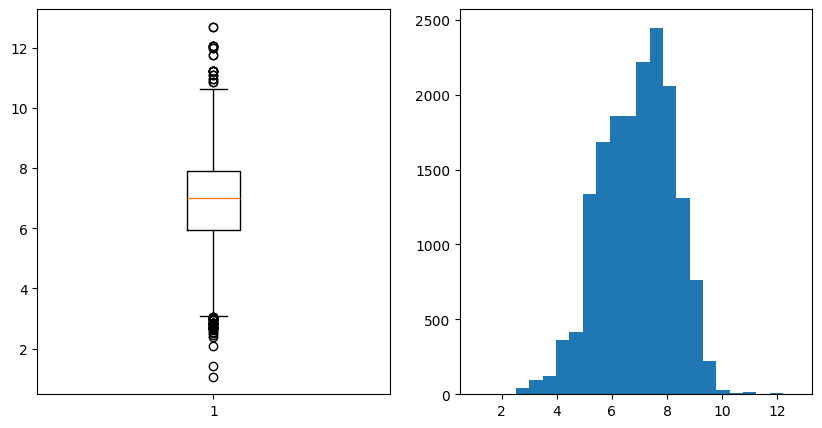

count    16853.000000
mean         6.912523
std          1.325182
min          1.065502
25%          5.958607
50%          7.017729
75%          7.890000
max         12.698970
Name: pIC50, dtype: float64

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].boxplot(df['pIC50'])
ax[1].hist(df['pIC50'], bins=24)
plt.show()

display(df['pIC50'].describe())

Величины $\text{pIC}_{50}$ валидны, имеют достаточно симметричное унимодальное распределение.

## `MolWt`

MolWt (Molecular Weight, молекулярная масса) — сумма атомных масс всех атомов в молекуле, измеряется в граммах на моль (г/моль), или дальтонах (Да).

В фармакологии под малыми молекулами обычно понимают соединения с молекулярной массой $≤ 900$ Да, чаще до $500$ Да.

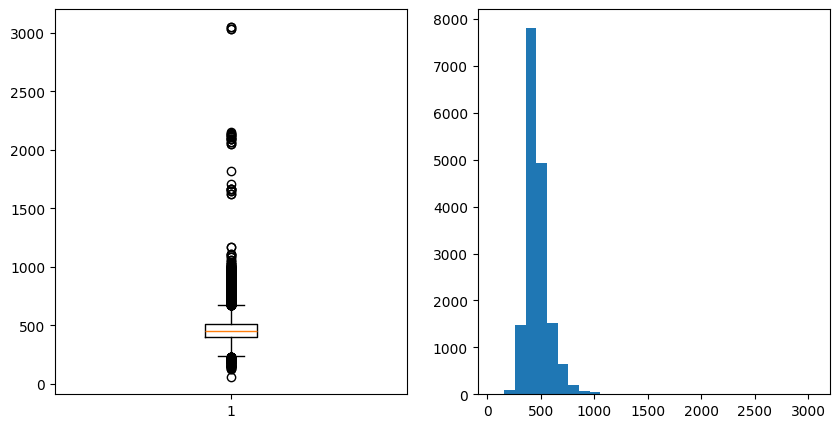

count    16853.000000
mean       469.828003
std        128.153397
min         61.084000
25%        400.523010
50%        448.618011
75%        510.628998
max       3052.576904
Name: MolWt, dtype: float64

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].boxplot(df['MolWt'])
ax[1].hist(df['MolWt'], bins=30)
plt.show()

display(df['MolWt'].describe())

Основная масса данных (до ~600 Да) — абсолютно реалистична и приемлема для малых молекул. Среднее и медиана (~450–470 Да) находятся точно в оптимальном диапазоне для ингибиторов β-секретазы (350–550 Да).

Значения больше 1000 Да — аномальные для малых молекул. Возможно, в выгрузку попадают пептиды, соли и др. Также, возможно, на этапе предобработки и преобразования IC50 в pIC50 не было фильтра по единицам измерения (нМ), что привело к смешанным единицам измерения.

Распределение унимодально и без аномалий может быть аппроксимировано нормальным.

## `MolLogP`

MolLogP является мерой липофильности — способности соединения растворяться в жирах, маслах и липидах. Этот параметр критически важен для абсорбции, распределения, метаболизма и выведения (ADME) лекарственного средства.

Теоретически возможный диапазон от примерно −10 до +10. Типичный для малых молекул (drug-like) - от −2 до +5. Выбросы (аномальные значения) - меньше −3 или больше 7.

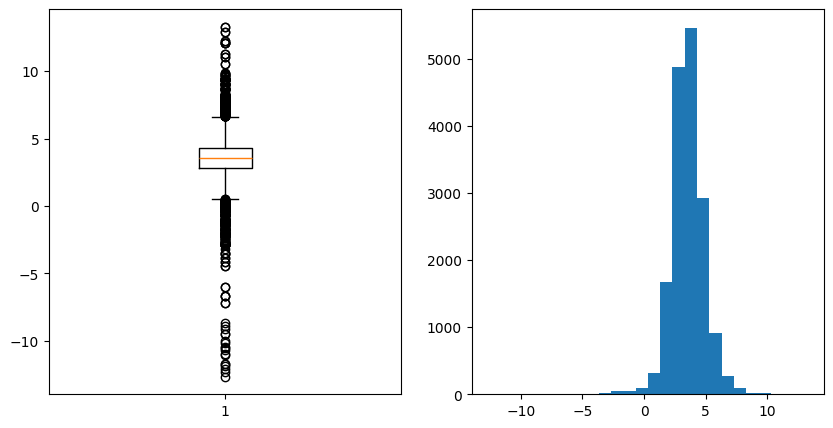

count    16853.000000
mean         3.556984
std          1.449627
min        -12.674500
25%          2.789220
50%          3.528800
75%          4.320100
max         13.296600
Name: MolLogP, dtype: float64

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].boxplot(df['MolLogP'])
ax[1].hist(df['MolLogP'], bins=26)
plt.show()

display(df['MolLogP'].describe())

Среднее значение $≈ 3.56$ и медиана $≈ 3.53$ находятся в "золотой середине" для лекарственных молекул. Они полностью соответствуют "Правилу пяти" Липински, согласно которому значение LogP для пероральных препаратов в идеале должно быть меньше 5.[1][2]

Межквартильный размах (от $25%$ до $75%$, то есть от $2.79$ до $4.32$) также лежит в пределах оптимального диапазона. Это говорит о том, что 50% всех соединений в выборке обладают очень хорошими показателями липофильности, что является благоприятным признаком.

Максимальное значение $≈ 13.30$ является явной аномалией. Молекулы с такой высокой липофильностью, как правило, обладают очень плохой растворимостью в воде, что делает их биодоступность крайне низкой. Кроме того, они могут накапливаться в жировых тканях, что затрудняет их выведение из организма и может приводить к токсичности.[1][2] Это значение — явный кандидат на удаление из набора данных.

Минимальное значение (min) $≈ -12.67$ - это аномально низкое значение, указывающее на чрезвычайно высокую гидрофильность (растворимость в воде). Такие соединения, скорее всего, будут иметь серьезные проблемы с проникновением через клеточные мембраны, чтобы достичь своей мишени (например, β-секретазы внутри клетки или в ЦНС), что также негативно скажется на их эффективности.

Основная часть данных (более $75%$) выглядит абсолютно адекватно для дальнейшей разработки моделей QSAR. Однако, как и в случае с MolWt, в данных присутствуют экстремальные выбросы.

Возможные причины аномалий совпадают со случаем `MolWt`.

Распределение унимодально и без аномалий может быть аппроксимировано нормальным.

## `NumHDonors`

Количество доноров водородных связей в молекуле (обычно атомы кислорода и азота, связанные с водородом). Этот параметр является ключевым для оценки "лекарственноподобных" свойств соединения, так как он влияет на растворимость и способность молекулы проникать через биологические мембраны.

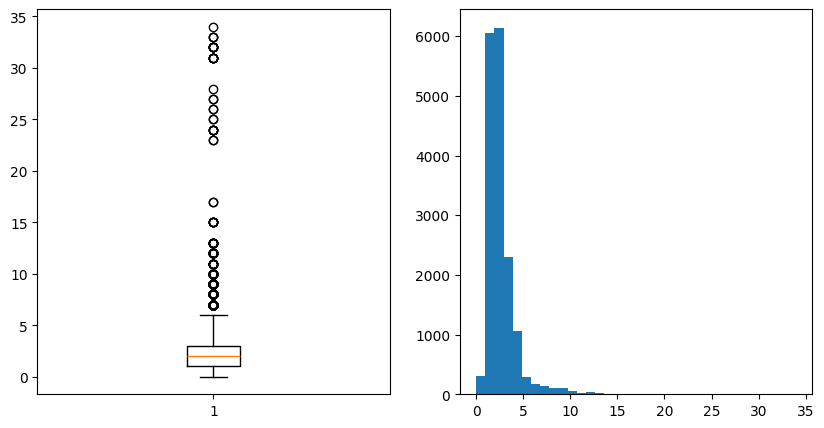

count    16853.000000
mean         2.206373
std          1.975194
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         34.000000
Name: NumHDonors, dtype: float64

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].boxplot(df['NumHDonors'])
ax[1].hist(df['NumHDonors'], bins=35)
plt.show()

display(df['NumHDonors'].describe())

Среднее $≈ 2.21$ и медиана $= 2.0$ - практически идеальные. Согласно "Правилу пяти" Липински, для хорошей пероральной биодоступности у молекулы должно быть не более 5 доноров водородных связей. Межквартильный размах: $75%$ молекул в выборке имеют 3 или менее доноров водородных связей. Это означает, что подавляющее большинство соединений полностью соответствует одному из важнейших критериев лекарственноподобия. Такое распределение указывает на высокое качество основной части датасета.

Максимальное значение $= 34.0$ является экстремальным и однозначно аномальным для малой лекарственной молекулы. Соединение с 34 донорами водородных связей будет чрезвычайно полярным, что, скорее всего, сделает невозможным его проникновение через клеточные мембраны для достижения мишени.

Распределение унимодально и без аномалий может быть аппроксимировано нормальным.

## `NumHAcceptors`

Количество атомов (обычно кислород и азот), способных принимать участие в образовании водородной связи. Этот параметр, как и число доноров, напрямую влияет на полярность молекулы и ее способность проходить через биологические мембраны. Согласно самому известному набору правил в медицинской химии, "Правилу пяти" Липински, для хорошей пероральной биодоступности (способности всасываться в ЖКТ) молекула должна иметь не более 10 акцепторов водородных связей.

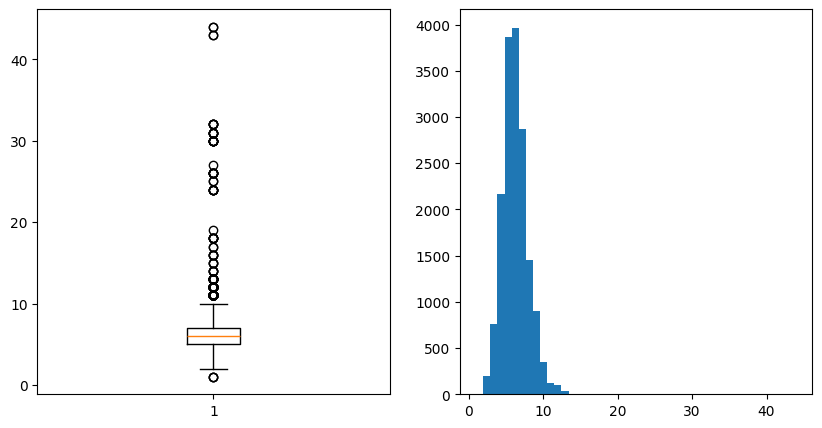

count    16853.000000
mean         6.070373
std          2.159503
min          1.000000
25%          5.000000
50%          6.000000
75%          7.000000
max         44.000000
Name: NumHAcceptors, dtype: float64

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].boxplot(df['NumHAcceptors'])
ax[1].hist(df['NumHAcceptors'], bins=45)
plt.show()

display(df['NumHAcceptors'].describe())

Картина полностью повторяет предыдущие наблюдения. Без учёта аномалий достаточно симметричное унимодальное распределение.

## `NumRotatableBonds`

Число вращающихся (ротабельных) связей. Этот параметр описывает конформационную гибкость молекулы. Слишком "гибкая" молекула (с большим числом вращающихся связей) теряет энтропию при связывании с мишенью, что энергетически невыгодно и может ослабить её активность. С другой стороны, слишком "жёсткая" молекула может быть неспособна принять оптимальную конформацию для связывания.

Ожидаемый нормальный диапазон — от 0 до 10.

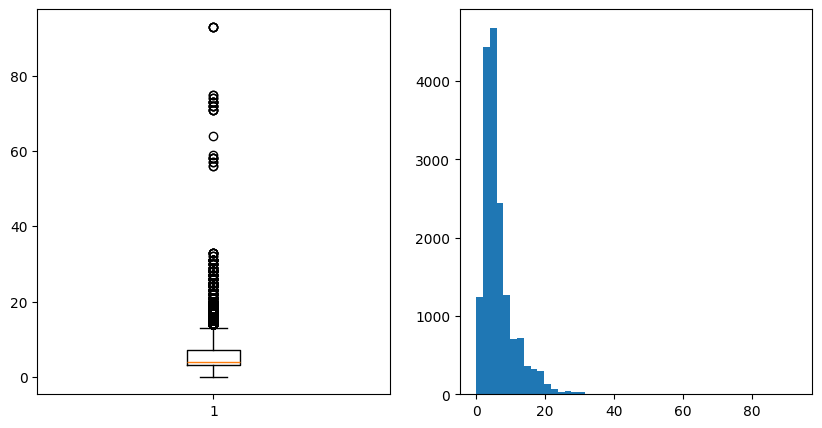

count    16853.000000
mean         6.071026
std          5.443983
min          0.000000
25%          3.000000
50%          4.000000
75%          7.000000
max         93.000000
Name: NumRotatableBonds, dtype: float64

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].boxplot(df['NumRotatableBonds'])
ax[1].hist(df['NumRotatableBonds'], bins=47)
plt.show()

display(df['NumRotatableBonds'].describe())

Картина повторяет предыдущие наблюдения.

Распределение унимодально и смещено влево.

## `RingCount`

Количество колец описывает структурную сложность и каркас молекулы. Кольцевые структуры являются основой подавляющего большинства лекарственных препаратов.

Ожидаемый нормальный диапазон для RingCount — от 1 до 5, с "идеальным" центром в районе 2-4 колец.

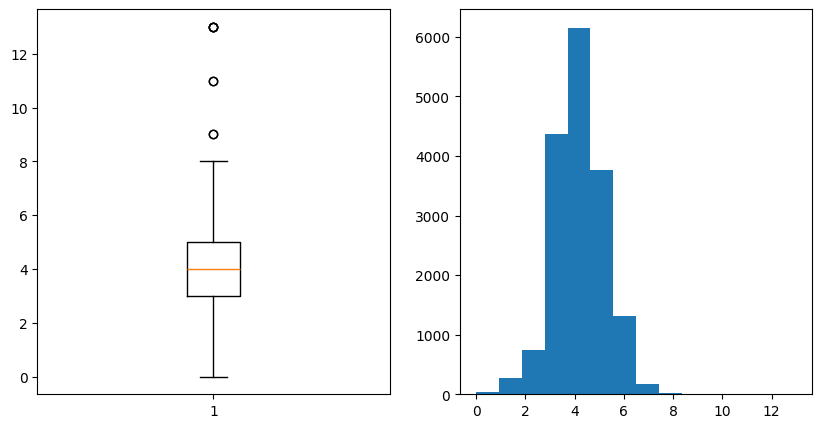

count    16853.000000
mean         4.012520
std          1.136598
min          0.000000
25%          3.000000
50%          4.000000
75%          5.000000
max         13.000000
Name: RingCount, dtype: float64

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].boxplot(df['RingCount'])
ax[1].hist(df['RingCount'], bins=14)
plt.show()

display(df['RingCount'].describe())

Подавляющее большинство данных (>75%) идеально соответствует профилю известных лекарств. Центральная тенденция и разброс данных указывают на очень релевантную выборку молекул. Выбросы существуют, но они не такие экстремальные.

Достаточно симметричное унимодальное распределение.

## `NumAromaticRings`

Количество ароматических колец — критически важный параметр. Ароматические кольца часто являются ключевыми элементами для связывания с белком-мишенью (например, через π-π стэкинг). Однако их избыток может привести к проблемам

Ожидаемый нормальный диапазон для NumAromaticRings — от 1 до 4.

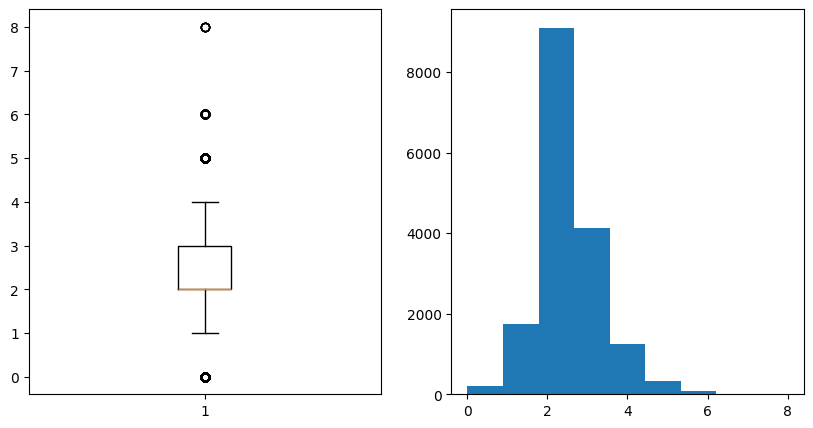

count    16853.000000
mean         2.344568
std          0.911530
min          0.000000
25%          2.000000
50%          2.000000
75%          3.000000
max          8.000000
Name: NumAromaticRings, dtype: float64

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].boxplot(df['NumAromaticRings'])
ax[1].hist(df['NumAromaticRings'], bins=9)
plt.show()

display(df['NumAromaticRings'].describe())

Подавляющее большинство данных идеально. Центральная тенденция и разброс практически полностью соответствуют профилю успешных лекарственных препаратов. Выбросы четко определены и немногочисленны.

Достаточно симметричное унимодальное распределение.

## `TPSA`

TPSA (Topological Polar Surface Area — Топологическая Полярная Поверхностная Площадь) — это дескриптор, который суммирует площадь поверхности полярных атомов в молекуле (в основном, кислорода и азота, включая связанные с ними атомы водорода). Этот параметр является одним из самых мощных предикторов способности молекулы проникать через клеточные мембраны.

Ожидаемый нормальный диапазон для пероральных лекарств — от 20 до 140 Å².

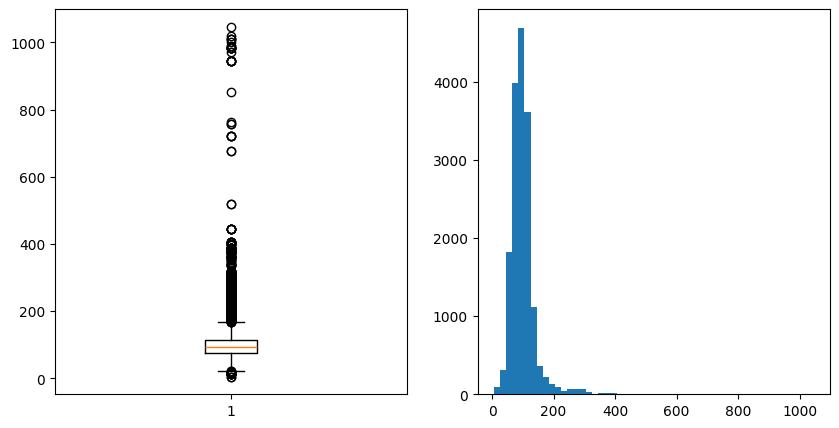

count    16853.000000
mean       100.818665
std         54.231869
min          4.930000
25%         75.989998
50%         93.809998
75%        112.870003
max       1046.209961
Name: TPSA, dtype: float64

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].boxplot(df['TPSA'])
ax[1].hist(df['TPSA'], bins=52)
plt.show()

display(df['TPSA'].describe())

Распределение TPSA подтверждает общую картину, сложившуюся ранее. Датасет имеет ядро (75% и более) из высококачественных молекул, но содержит значительное число аномальных молекул.

Без учёта аномалий достаточно симметричное унимодальное распределение.

# Взаимосвязи

In [17]:
corr_df = df.corr(numeric_only=True)

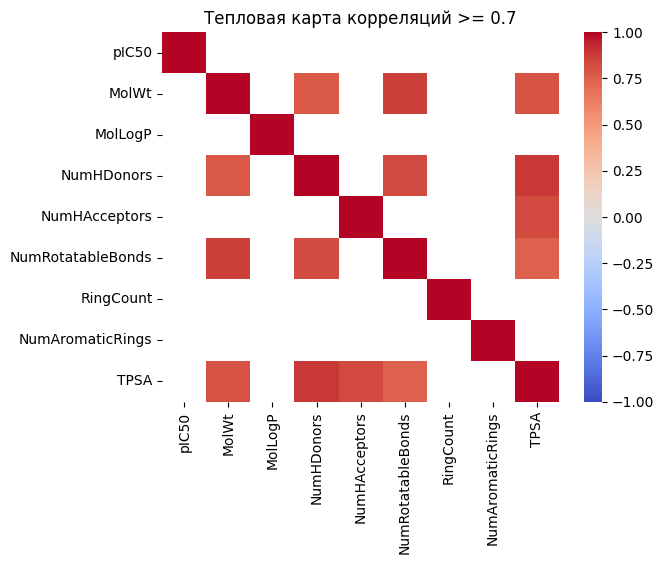

In [18]:
cmap = sns.color_palette("coolwarm", as_cmap=True)
plt.title('Тепловая карта корреляций >= 0.7')
sns.heatmap(corr_df[abs(corr_df) >= 0.7], vmin=-1, vmax=1, cmap=cmap)
plt.show()

Ни один из рассчитанных физико-химических дескрипторов не имеет сильной прямой корреляции (>= 0.7) с целевой переменной pIC50.

Обнаруженные сильные линейные взаимосвязи:

- `MolWt` и другие признаки (MolLogP, NumHDonors, NumRotatableBonds, TPSA). Молекулярный вес является очень "базовым" свойством. Чем больше и тяжелее молекула, тем больше в ней может быть различных функциональных групп, колец и гибких связей.
- `TPSA` и другие признаки (NumHDonors и NumHAcceptors). TPSA (топологическая полярная поверхностная площадь) по своему определению рассчитывается на основе атомов кислорода и азота, которые как раз и являются донорами и акцепторами водородных связей.

Данные избыточны: сильная мультиколлинеарность между дескрипторами.

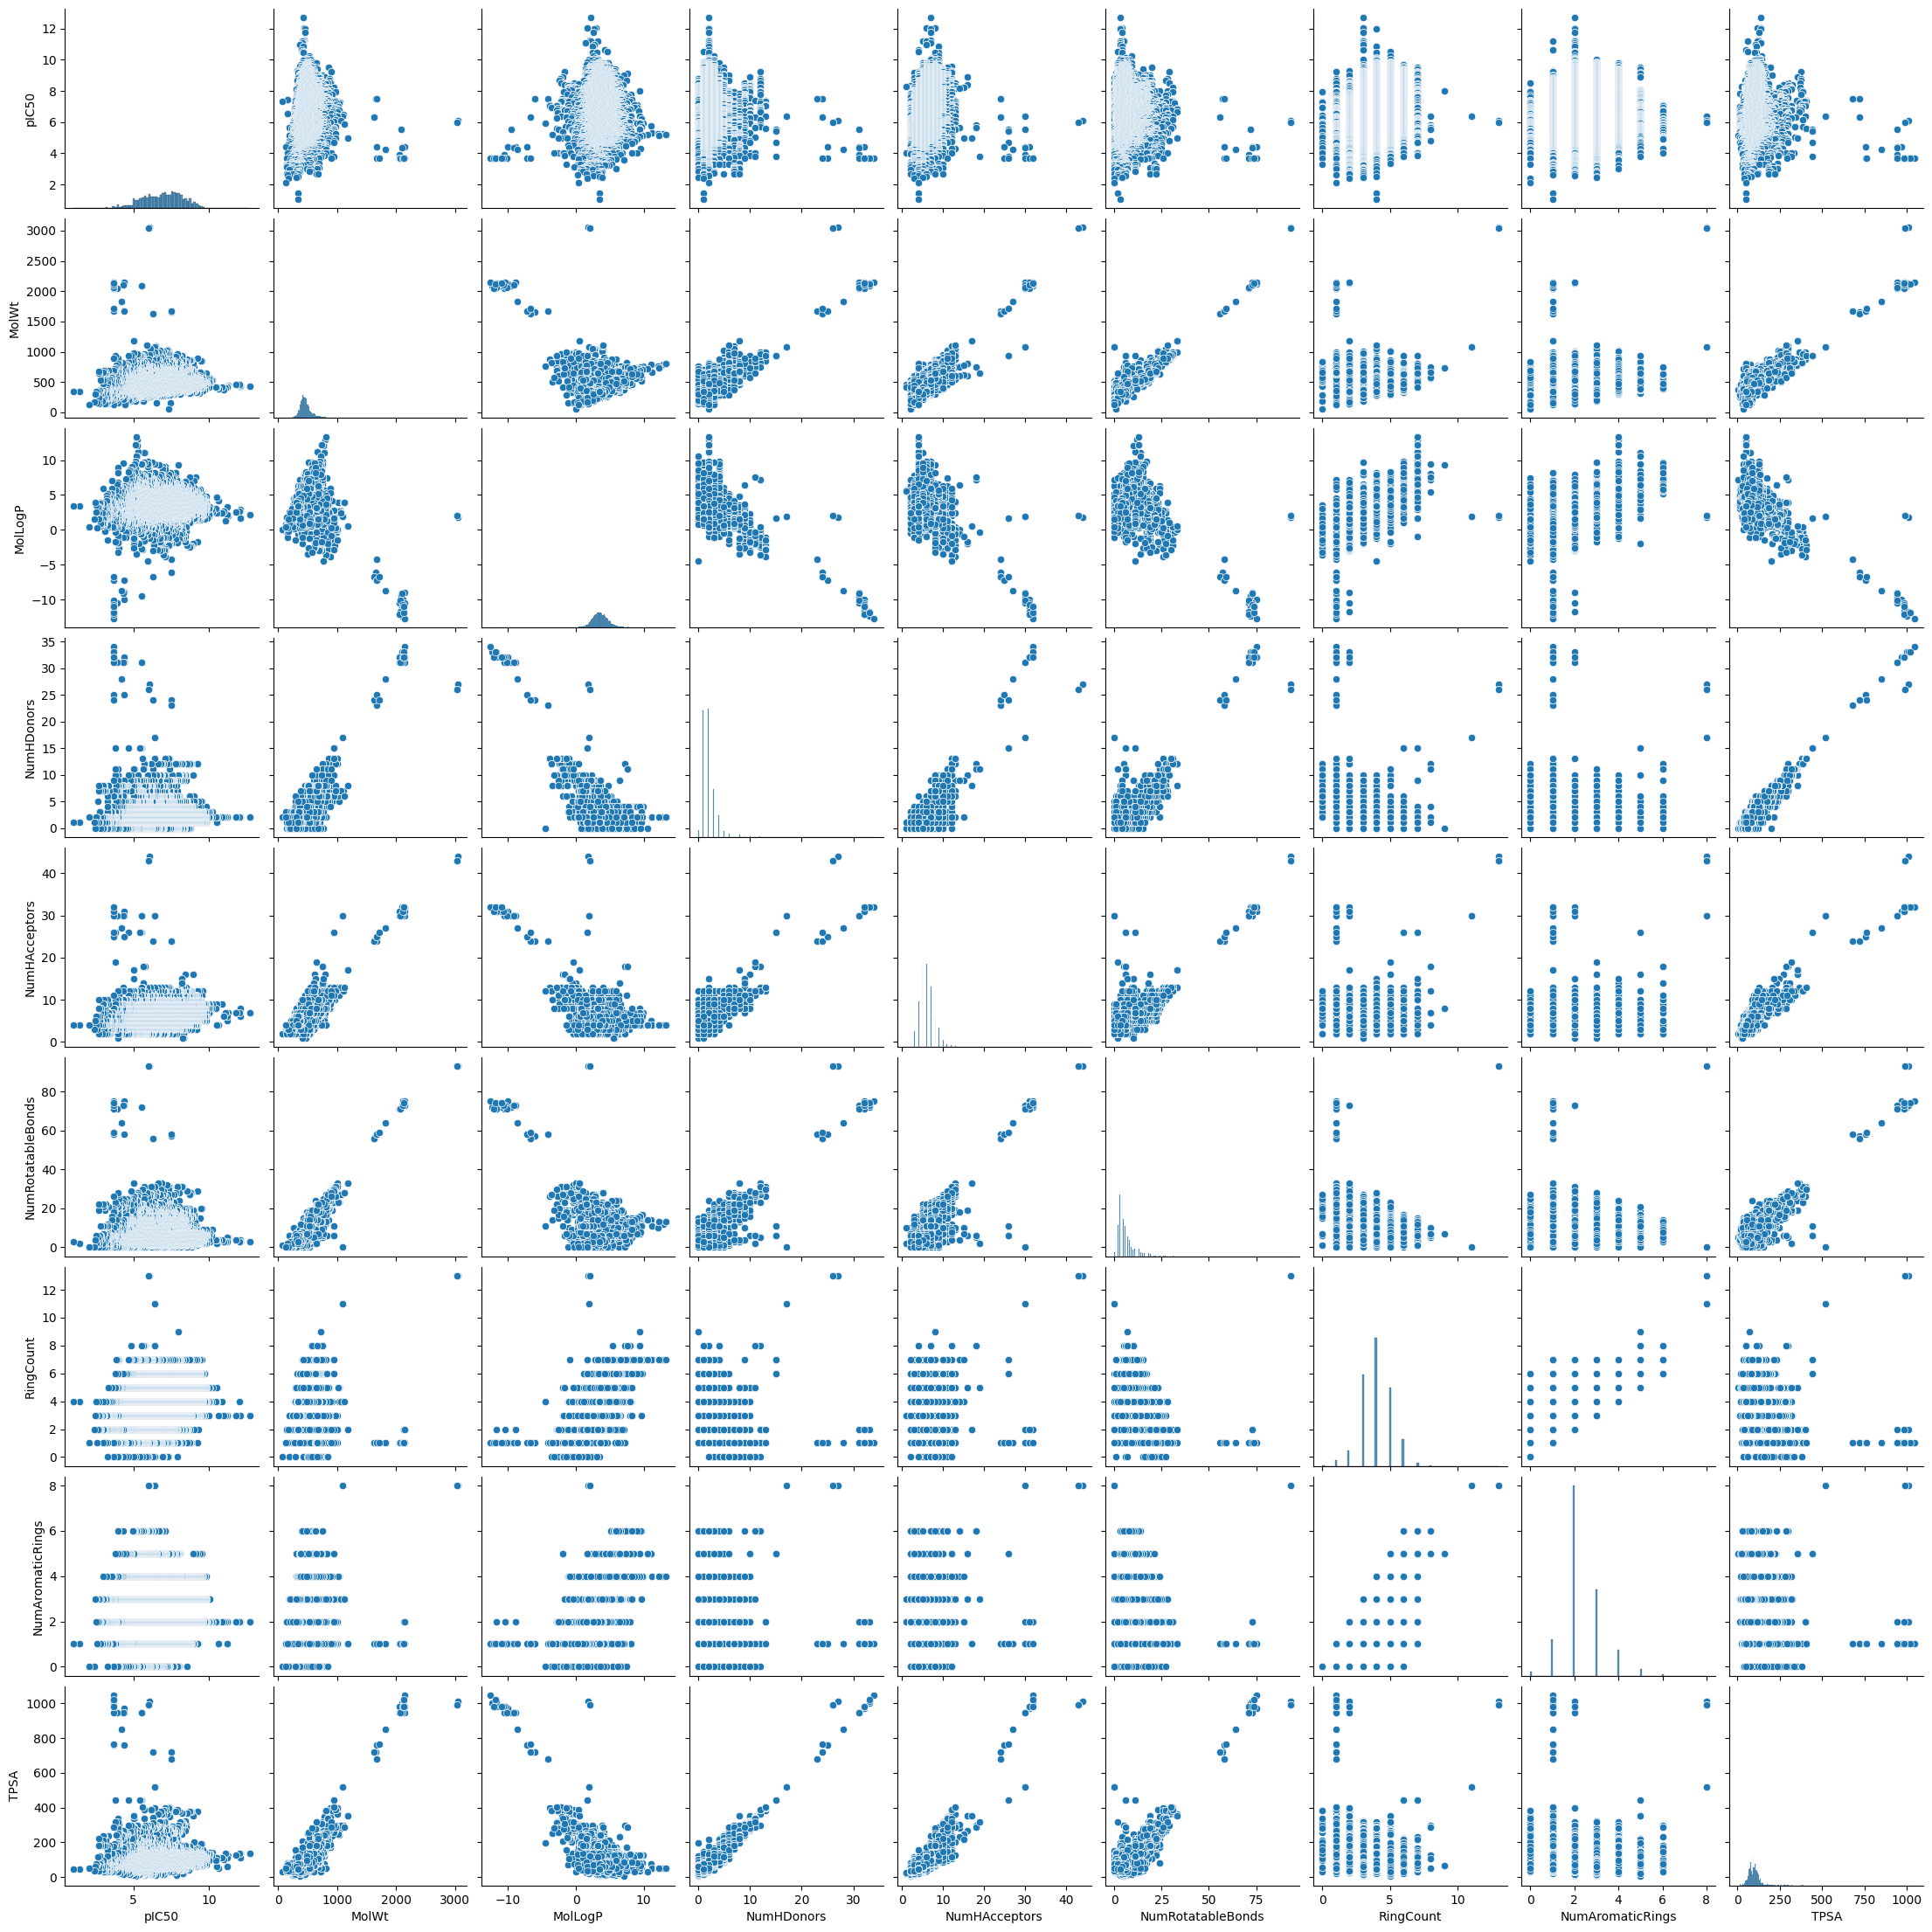

In [19]:
sns.pairplot(df)
plt.show()

На попарных диаграммах рассеяния также видим:

- сильные линейные взаимосвязи между некоторыми признаками,
- отсутствие явных полиномиальных связей,
- явное группирование выбросов в отдельный кластер.

# Метрики качества данных

In [20]:
total_cells = df.size
filled_cells = df.notna().sum().sum()
completeness_score = filled_cells / total_cells

uniqueness_score = df['canonical_smiles'].nunique() / len(df)

valid_df = df[
    (df['MolWt'] < 600) &
    (df['MolLogP'] >= -2) & (df['MolLogP'] <= 5) &
    (df['TPSA'] < 140) &
    (df['NumHDonors'] <= 5)
]
validity_score = len(valid_df) / len(df)

conformity_score = len(non_canonical_smiles_indexes) / len(df)

In [21]:
print('Completeness:', round(completeness_score, 2))
print('Uniqueness:', round(uniqueness_score, 2))
print('Validity:', round(validity_score, 2))
print('Conformity:', round(conformity_score, 2))

Completeness: 1.0
Uniqueness: 1.0
Validity: 0.78
Conformity: 0.48


# Выводы

- Данные полные, структурированные и целостные.
- Основная масса данных (78%) релевантна и подходит для задачи.
- Ключевая проблема — присутствие выбросов, которые представляют собой молекулы другого класса (не "малые молекулы").